In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
# > for cm: row is true, col is prediction
from sklearn.metrics import matthews_corrcoef, f1_score, cohen_kappa_score
import matplotlib.pyplot as plt
# self-written functions:
import sys
sys.path.append("../data_process/")
sys.path.append("../modeling/")
import ML_func as ml
import data_cleaner as dc

In [32]:
# load data
test = dc.load_py('../../clean_data/test.pkl')   # CatBoost & light GBM use categorical
train = dc.load_py('../../clean_data/train.pkl')
x_test_dummy = dc.load_py('../../clean_data/test_dummy.pkl')    # XGBoost use one-hot encoding
x_train_dummy = dc.load_py('../../clean_data/train_dummy.pkl')
x_test_dummy.pop('progress')   
x_train_dummy.pop('progress')
x_test = test.copy()
x_train = train.copy()
y_test = x_test.pop('progress')
y_train = x_train.pop('progress')
cat_features = ['PTGENDER', 'PTETHCAT', 'PTMARRY', 'PTRACCAT']

In [33]:
def get_pred(model, x):
    y_pred = model.predict(x)
    y_prob = model.predict_proba(x)[:,1]
    return y_pred, y_prob
def bi_scores(y_true, y_pred, y_prob):     # evaluation metrics for binary case
    acc = format(np.mean(y_true == y_pred),'.4f' )      # accuracy
    auc = roc_auc_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kp = cohen_kappa_score(y_true, y_pred)
    cm = confusion_matrix(y_true,y_pred)
    recall = cm[1,1]/cm.sum(axis=1)[1]
    precision = cm[1,1]/cm.sum(axis=0)[1]
    return {'MCC':mcc, 'AUC':auc, 'Accuracy':acc, 
            'Recall':recall, 'Precision':precision,'F1-Score':f1, 'Kappa':kp}

In [34]:
# load models:
import re
from glob import glob
models = dc.load_py('../modeling/models/baseline5.pkl')
files = glob('../modeling/models/*_optimal*')
for fl in files:
    nm = re.split('_|/', fl)[3]  # name of model
    models[nm] = dc.load_py(fl)
print(models.keys() )

dict_keys(['Logistic Regression', 'Lasso Regression', 'Random Forest', 'SVM', 'GBM', 'CatBoost', 'XGBoost', 'LightGBM'])


In [35]:
# training
table1 = {}
preds = {}
for nm, model in models.items():
    # get predicted values:
    if nm == 'CatBoost':
        y_pred, y_prob = get_pred(model, x_train)
    elif nm == 'LightGBM':
        x_train_lgb = x_train.copy()
        for c in cat_features:
            x_train_lgb[c] = x_train_lgb[c].astype('category')
        y_pred, y_prob = get_pred(model, x_train_lgb)
    else:
        y_pred, y_prob = get_pred(model, x_train_dummy)
    # save the probs for ROC curve:
    preds[nm] = y_pred, y_prob
    # calculate metrices:
    table1[nm] = bi_scores(y_train, y_pred, y_prob)
pd.DataFrame(table1).T.sort_values('MCC', ascending=False).astype('float32').round(4)

,MCC,AUC,Accuracy,Recall,Precision,F1-Score,Kappa
Random Forest,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
GBM,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
XGBoost,0.8964,0.9818,0.9681,0.8742,0.9586,0.9145,0.8949
CatBoost,0.8384,0.9831,0.9510,0.7799,0.9612,0.8611,0.8317
LightGBM,0.7808,0.9709,0.9228,0.9182,0.7449,0.8225,0.7739
SVM,0.5268,0.8791,0.8652,0.5031,0.7207,0.5926,0.5149
Logistic Regression,0.1630,0.7408,0.8113,0.0629,0.6667,0.1149,0.0842
Lasso Regression,0.1630,0.7408,0.8113,0.0629,0.6667,0.1149,0.0842


In [38]:
# testing
table1 = {}
preds = {}
for nm, model in models.items():
    # get predicted values:
    if nm == 'CatBoost':
        y_pred, y_prob = get_pred(model, x_test)
    elif nm == 'LightGBM':
        x_test_lgb = x_test.copy()
        for c in cat_features:
            x_test_lgb[c] = x_test_lgb[c].astype('category')
        y_pred, y_prob = get_pred(model, x_test_lgb)
    else:
        y_pred, y_prob = get_pred(model, x_test_dummy)
    # save the probs for ROC curve:
    preds[nm] = y_pred, y_prob
    # calculate metrices:
    table1[nm] = bi_scores(y_test, y_pred, y_prob)
pd.DataFrame(table1).T.sort_values('MCC', ascending=False).astype('float32').round(4)

,MCC,AUC,Accuracy,Recall,Precision,F1-Score,Kappa
CatBoost,0.4630,0.8787,0.9280,0.4643,0.5417,0.5000,0.4614
SVM,0.4379,0.8059,0.9169,0.5000,0.4667,0.4828,0.4376
Random Forest,0.4146,0.8715,0.9252,0.3929,0.5238,0.4490,0.4097
LightGBM,0.4050,0.8725,0.8837,0.6071,0.3542,0.4474,0.3873
XGBoost,0.3999,0.8739,0.9169,0.4286,0.4615,0.4444,0.3996
GBM,0.3060,0.8737,0.9086,0.3214,0.3913,0.3529,0.3043
Logistic Regression,-0.0153,0.7644,0.9197,0.0000,0.0000,0.0000,-0.0054
Lasso Regression,-0.0153,0.7650,0.9197,0.0000,0.0000,0.0000,-0.0054


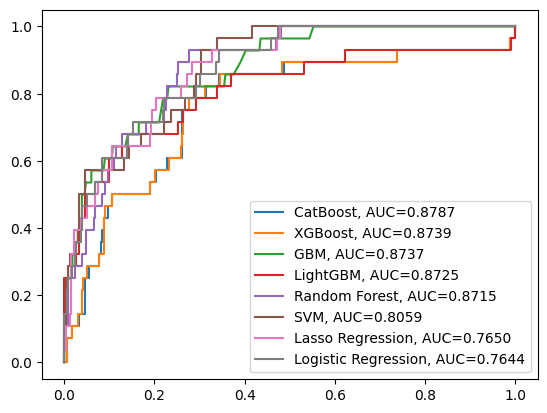

In [37]:
# ROC curve
plt.figure(0).clf()
labels = []  # to reorder using auc value
for nm, (y_pred, y_prob) in preds.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = format(roc_auc_score(y_test, y_prob), '.4f')
    label = f"{nm}, AUC={str(auc)}"
    labels.append((auc, label))
    plt.plot(fpr,tpr,label=label)
# sort the labels based on auc values
labels.sort(reverse=True)
sorted_labels = [label for auc, label in labels]
plt.legend(sorted_labels)
plt.savefig('../output/roc_curve.svg', dpi=300)